# Анализ результативности футбольных команд

Команда «Е.Д.А.»
 - Максимов Дмитрий Николаевич
 - Никитина Елизавета Андреевна
 - Соловьев Александр Сергеевич 

## Шаг 1. Тема и общее описание проекта

В футболе существует огромное количество статистики по итогам матчей — количество пасов/навесов, xG (Expected Goals), доля ударов в створ и многое другое. Наша команда заинтересовалась, можно ли по этой статистике оценивать результативность футбольной команды и, соответственно, пытаться предсказывать исход матчей.

Для этого мы решили взглянуть на последние несколько сезонов Английской Премьер лиги и поставили задачу предугадать чемпиона текущего сезона. В качестве основного источника данных мы взяли сайт https://fbref.com/en/, так как он предоставляет большое количество статистики

## Шаг 2. Сбор данных

### Как мы собирали данные?
Fbref имеет некоторые ограничения для сбора данных — слишком частые запросы (больше 20 в минуту) блокируются, поэтому в одной из версий парсера мы решили расставить паузы так, чтобы не нарушать это требование со стороны fbref. В итоге необходимые данные мы скачали за примерно 1.5 часа. 
Код парсера можно посмотреть [здесь](https://github.com/asolovyov03/soccer-analysis/blob/main/scripts/parse.py)

Итоговые данные мы сохранили в файл [match_stats.json](https://github.com/asolovyov03/soccer-analysis/blob/main/match_stats.json)

### Какие данные мы собрали?
Мы решили взять статистику всех матчей АПЛ с сезона 2018-2019 по текущий (последний матч на момент парсинга прошёл 8 мая)
Для домашней и гостевой команды мы собрали следующие признаки:
- **team**: название команды
- **score**: количество голов, которая команда забила по итогам матча
- **xG**: показатель Expected Goals (расчитана аналитической компанией Opta)
- **possession**: доля владения мячом
- **passing_accuracy**: точность пасов (доля успешных пасов)
- **shots_on_target**: доля ударов в створ
- **yellow_cards_count**: количество желтых карточек
- **red_cards_count**: количество красных карточек
- **fouls**: количество совершенных фолов
- **corners**: количество угловых
- **crosses**: количество навесов
- **touches**: количество касаний мяча
- **tackles**: количество перехватов
- **interceptions**: количество отборов мяча
- **aerials_won**: количество выигрышей мяча в воздухе
- **clearances**: количество выбитых мячей
- **offsides**: количетсво попаданий в оффсайд
- **goal_kicks**: количество ударов от ворот
- **throw_ins**: количество вбросов в игру
- **long_balls**: количество дальних передач
- **match_date**: дата матча
- **match_week**: номер недели чемпионата

## Шаг 3. Предварительная обработка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
with open("match_stats.json") as file:
    matches = json.loads(file.read())
stat_keys = matches[0]['home'].keys()
data = {}
data.update({'home_' + k: [] for k in stat_keys})
data.update({'guest_' + k: [] for k in stat_keys})

for match in matches:
    for key in match['home'].keys():
        data['home_' + key].append(match['home'][key])
    for key in match['guest'].keys():
        data['guest_' + key].append(match['guest'][key])

df = pd.DataFrame(data)

Взгляним на то, что из себя представляет полученный df

In [3]:
df.head()

,home_team,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,...,guest_crosses,guest_touches,guest_tackles,guest_interceptions,guest_aerials_won,guest_clearances,guest_offsides,guest_goal_kicks,guest_throw_ins,guest_long_balls
0,Crystal Palace,0,1.2,0.56,0.84,0.20,1,0,16,3,...,11,599,29,9,14,24,2,2,14,59
1,Fulham,2,1.2,0.33,0.60,0.25,2,0,7,4,...,18,784,11,10,13,16,4,5,35,94
2,Tottenham Hotspur,4,1.5,0.58,0.83,0.44,3,0,11,10,...,18,554,14,13,11,21,0,4,14,61
3,Newcastle United,2,1.7,0.61,0.79,0.39,0,0,9,11,...,9,475,15,10,16,37,0,12,26,70
4,Leeds United,2,0.8,0.40,0.74,0.33,2,0,13,6,...,20,720,16,14,7,17,1,9,23,72


Посчитаем основные статистики для наших признаков

In [4]:
df.describe()

,home_score,home_xG,home_possession,home_passing_accuracy,home_shots_on_target,home_yellow_cards_count,home_red_cards_count,home_fouls,home_corners,home_crosses,...,guest_crosses,guest_touches,guest_tackles,guest_interceptions,guest_aerials_won,guest_clearances,guest_offsides,guest_goal_kicks,guest_throw_ins,guest_long_balls
count,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,...,1834.00000,1834.000000,1834.000000,1834.000000,1834.000000,1834.000000,1834.00000,1834.000000,1834.000000,1834.000000
mean,1.504907,1.459597,0.509553,0.770365,0.332770,1.607961,0.034351,10.491821,5.648310,19.647764,...,16.40458,606.242094,16.541439,10.338059,16.693566,22.523991,1.71265,7.833697,20.131407,68.393130
std,1.324670,0.822911,0.126357,0.074203,0.154987,1.244984,0.190952,3.407925,3.062734,8.356045,...,7.49540,133.001931,5.227156,4.130337,6.994573,10.120319,1.48929,3.465855,6.070747,13.462878
min,0.000000,0.000000,0.180000,0.490000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.00000,299.000000,3.000000,0.000000,1.000000,1.000000,0.00000,0.000000,3.000000,30.000000
25%,1.000000,0.800000,0.420000,0.720000,0.230000,1.000000,0.000000,8.000000,3.000000,13.000000,...,11.00000,502.000000,13.000000,7.000000,12.000000,15.000000,1.00000,5.000000,16.000000,59.000000
50%,1.000000,1.400000,0.510000,0.780000,0.330000,1.000000,0.000000,10.000000,5.000000,19.000000,...,16.00000,596.000000,16.000000,10.000000,16.000000,21.000000,1.00000,8.000000,20.000000,67.000000
75%,2.000000,2.000000,0.610000,0.830000,0.430000,2.000000,0.000000,13.000000,8.000000,25.000000,...,21.00000,696.750000,20.000000,13.000000,21.000000,28.000000,3.00000,10.000000,24.000000,78.000000
max,9.000000,5.900000,0.820000,0.920000,1.000000,7.000000,2.000000,23.000000,17.000000,62.000000,...,53.00000,1063.000000,46.000000,29.000000,52.000000,80.000000,10.00000,23.000000,44.000000,127.000000


Проверим, есть ли пропуски в данных

In [5]:
df.isna().any().any()

False

Пропуски отсутствуют

## Шаг 4. Визуализация

Попробуем посмотреть, есть ли некоторые ожидаемые закономерности в наших данных, с помощью визуализации

Сравним количество забитых голов дома и в гостях (принято считать, что в гостях играть сложнее)

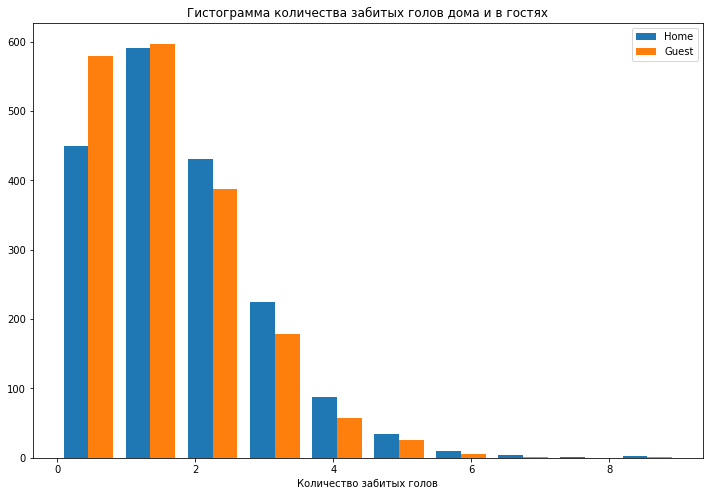

In [6]:
plt.figure(figsize=(12,8))
plt.hist([df['home_score'], df['guest_score']], label=['Home', 'Guest'])
plt.title("Гистограмма количества забитых голов дома и в гостях")
plt.xlabel("Количество забитых голов")
plt.legend();

Заметно, что у распределения голов гостей более тяжелый левый хвост. Они чаще не забивают вовсе или ограничиваются одним голом, хозяева же чаще результативнее. Можно предположить, что это связано со тактикой команды — в гостях больше защищаемся и менее активно атакуем. Давайте попробуем это проверить

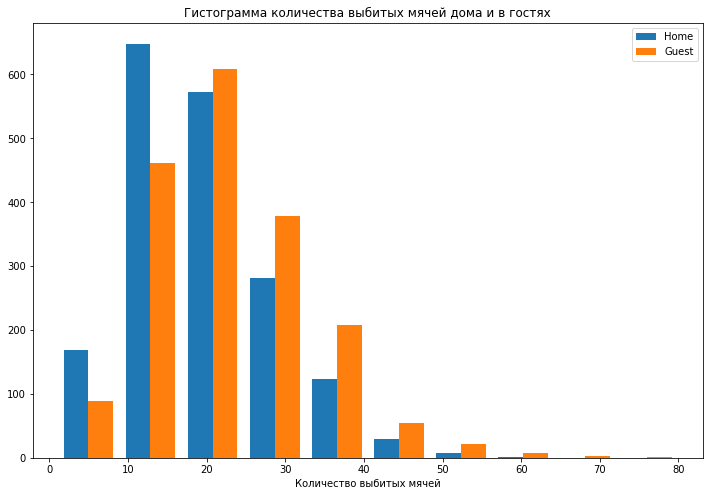

In [7]:
plt.figure(figsize=(12,8))
plt.hist([df['home_clearances'], df['guest_clearances']], label = ['Home', 'Guest'])
plt.title("Гистограмма количества выбитых мячей дома и в гостях")
plt.xlabel("Количество выбитых мячей")
plt.legend();

Видно, что гости заметно чаще выбивают мяч, посмотрим другие показатели игры от защиты

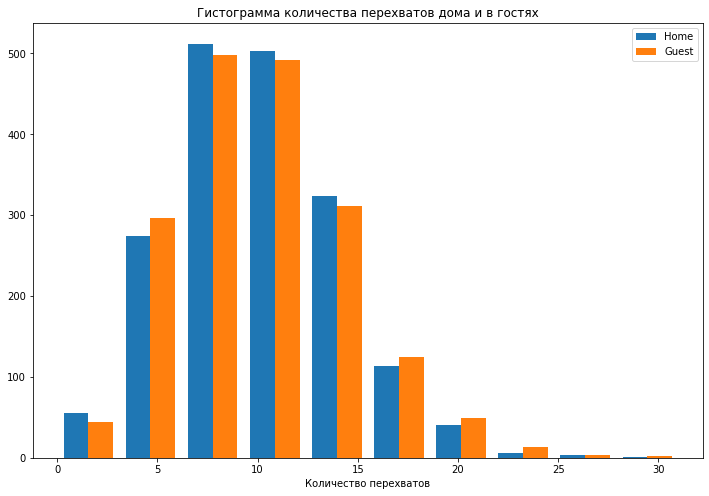

In [8]:
plt.figure(figsize=(12, 8))
plt.hist([df['home_interceptions'], df['guest_interceptions']], label=['Home', 'Guest'])
plt.title("Гистограмма количества перехватов дома и в гостях")
plt.xlabel("Количество перехватов")
plt.legend();

А в количестве отборов различий нет. Интересно! Давайте посмотрим на корреляцию между показателями, связанными с игрой в защите и возможно найдем что-то интересное

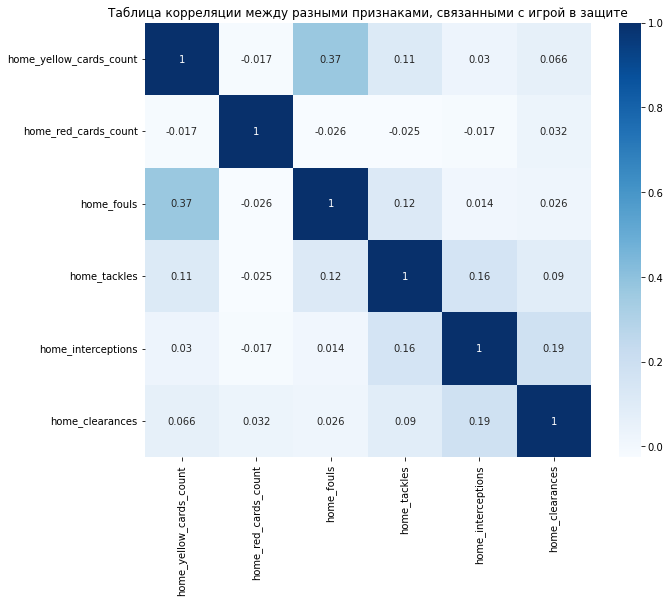

In [9]:
defensive_parametrs = ['home_yellow_cards_count', 'home_red_cards_count', 'home_fouls', 'home_tackles', 'home_interceptions', 'home_clearances']
plt.figure(figsize=(10, 8))
plt.title("Таблица корреляции между разными признаками, связанными с игрой в защите")
sns.heatmap(data=df[defensive_parametrs].corr(), annot=True, cmap='Blues');

Как заметно, почти везде корреляция достаточно слабая (кроме желтых карточек и фолов, что довольно очевидно). Об отсутствии зависимости говорить рано (вполне возможно она нелинейная), но это точно вопрос для дальнейшего изучения

Возможно низкая корреляция связана с тем, что каждый из этих показателей по-разному говорят об эффективности игры в защите. Например, перехват мяча позволяет дальше развить атаку, а выбивание его скорее говорит о неэффективности команды. Давайте сравним несколько показателей с количеством пропущенных и забитых голов

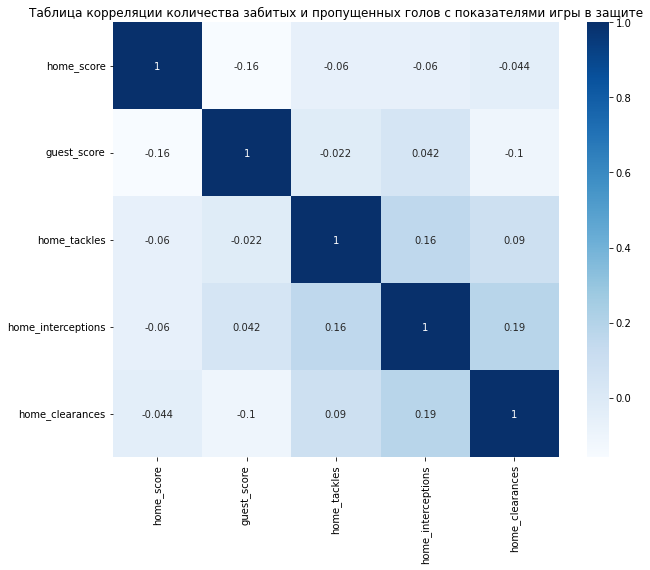

In [10]:
params = ['home_score', 'guest_score', 'home_tackles', 'home_interceptions', 'home_clearances']
plt.figure(figsize=(10, 8))
plt.title("Таблица корреляции количества забитых и пропущенных голов с показателями игры в защите")
sns.heatmap(data=df[params].corr(), annot=True, cmap='Blues');

Пока зависимостей в вопросах защиты особо не видно, оставим их поиск на более поздний этап

## Шаг 5. Создание новых признаков

## Шаг 6. Гипотезы

Так как мы собрали довольно много разной статистики, есть смысл поискать в ней какие-то иные взаимосвязи помимо корреляций и оформить это в виде тестирования гипотез. Ранее мы уже видели, как коррелируют разные футбольные показатели: количество ударов с количеством голов, количество фолов с количеством отборов и т.д. . Например, интересно было бы посмотреть на то, сможет ли команда статистически забить еще один гол, если подаст на 5 угловых больше, чем подала на самом деле? Подобные вопросы можно сформулировать применительно практически ко всем рассматриваемым нами показателям. Можно проверить, совершает ли команда больше фолов зимой и весной, когда в Англии дождливо и пасмурно, чем летом или ранней осенью, когда погода солнечная и газон на стадионе сухой. Такие гипотезы заканчиваются там, где заканчивается фантазия того, кто их проверяет. Мы протестируем несколько таких гипотез и посмотрим, как можно будет проинтерпретировать результаты наших тестов.

## Шаг 7. Машинное обучение

**Описание, как мы собираемся это делать**

Так как почти все наши признаки известны лишь после матча, предсказывать результат напрямую по ним не выйдет. Наша идея состоит в том, чтобы агрегировать признаки каждой команды за последние n матчей.
n будет гиперпараметром, который вероятно придётся подбирать, так как сразу сказать, сколько матчей брать — сложно. Если взять очень маленький период, то фактор везения или случайности будет слишком сильно влиять на результат, а если очень большой, то какие-то данные могут быть устаревшими (со временем в команде может меняться тактика, тренер, состав и многое другое, что серьёзно влияет на её результативность).

Имея агрегированные данные двух команд мы собираемся посчитать разницу (или отношение) между ними и на основе этого обучить логистическую регрессию для предсказания вероятности победы домашней команды. Далее мы подберем пороги вероятностей для определения победы, ничьи и поражения.

Возможно, если качество модели логистической регрессии будет низкое, мы попробуем другие модели для задачи многоклассовой классификации (например, деревья или бустинг), но пока это в наши планы не входит.